In [1]:
import os
import re
import numpy as np
import pandas as pd
from pandas import ExcelWriter

import seaborn as sns
from matplotlib import cm, rc
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

pd.set_option('display.max_rows', 10)

In [2]:
'''
Script for distribution plot of
distances between clusters
distance 1-2 -- double-negative vs double-positive
distance 1-3 -- double-negative vs FAM-negative
distance 2-3 -- double-positive vs FAM-negative
'''


# Defining distances between clusters
# Задаем расстояние между кластерами

def eu_distances(df):
    km = KMeans(n_clusters = 3, random_state = 1).fit(df)
    dists = euclidean_distances(km.cluster_centers_)
    tri_dists = dists[np.triu_indices(3, 1)]
    return tri_dists


# Calculating distances between clusters
# Считаем расстояние между кластерами по файлам в папке
# files, ddpcr, gdna или cdna

def calc_dist(dna_type, sample_type):
    ddpcr_path = os.path.join(os.getcwd(), "files", "ddpcr", dna_type)
    csv_files = os.listdir(ddpcr_path)
    x_y, x_z, y_z, titles = [], [], [], []
    for i in csv_files:
        result = re.findall(r"[25680][135]-\w+-" + "{}".format(sample_type), i)
        if result != []:
            name = result[0]
            titles.append(name)
            df = pd.read_csv(os.path.join(ddpcr_path, i))
            distance = eu_distances(df)
            x_y.append(distance[0]); x_z.append(distance[1]); y_z.append(distance[2])
    return x_y, x_z, y_z, titles
#     return distance


# Saving dist between clusters to xlsx file

def save_xlsx():
    vals = [["cDNA","alternative"],["gDNA","alternative"],["cDNA","reference"],["gDNA","reference"]]
    result = list_dfs()
    path = os.path.join(os.getcwd(), "files", "ddpcr", "dist.xlsx")
    with ExcelWriter(path) as writer:
        for n, df in enumerate(result):
            df.to_excel(writer, vals[n][0] + "_" + vals[n][1], index=False)
        writer.save()
    return "Done"


# Storing cluster distances

def store_dist(dna_type, sample_type):
    result = calc_dist(dna_type, sample_type)
    dists = result[0], result[1], result[2]
    rownames = pd.Series(result[3])
    df_dist = pd.DataFrame(list(dists))
    df_dist = df_dist.transpose()
    df_dist.columns=["1-2", "1-3", "2-3"]
    df_dist["patient_id"] = rownames
    df_dist = df_dist[["patient_id", "1-2", "1-3", "2-3"]]
    return df_dist


# Creating list of distances result 

def list_dfs():
    vals = [["cDNA","alternative"],["gDNA","alternative"],["cDNA","reference"],["gDNA","reference"]]
    result = []
    for i in vals:
        sdf = store_dist(i[0], i[1])
        result.append(sdf)
    return result


# Defining hist image properties
# Задаем вид рисунков
# plt.rc -- для теховских шрифтов

def hist_pics(x_y, x_z, y_z, name):
    
    fs=12
    sns.set(style="white", palette="muted", color_codes=True)
    f, ax = plt.subplots(figsize=(5, 5))
    
    params = {'mathtext.default': 'regular'}          
    plt.rcParams.update(params)
    
#     plt.rc('text', usetex=True)
#     plt.rc('font', **{'family': 'serif', "size":24})
#     plt.rc('text.latex', unicode=True)        
#     plt.rcParams['text.latex.preamble'] = [r'\usepackage[english,russian]{babel}', \
#                                            r'\usepackage[T2A]{fontenc}']
    
    sns.distplot(x_y, hist=False, color="r", kde_kws={"shade": True}, norm_hist=True, label="distance 1-2")
    sns.distplot(x_z, hist=False, color="g", kde_kws={"shade": True}, norm_hist=True, label="distance 1-3")
    sns.distplot(y_z, hist=False, color="b", kde_kws={"shade": True}, norm_hist=True, label="distance 2-3")
    ax.set_title(name, fontsize=fs+1)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    ax.legend(fontsize=fs-1)
    plt.xlabel("Distance between clusters", fontsize=fs)
    sns.despine()
    plt.tight_layout()
    return f, ax


# Creating hist plot for distances between clusters

def mhp(dna_type, sample_type):
#     if dna_type == "cDNA" and sample_type == "alternative": name = "кДНК альтернатива"
#     if dna_type == "gDNA" and sample_type == "alternative": name = "гДНК альтернатива"
#     if dna_type == "cDNA" and sample_type == "reference": name = "кДНК референс"
#     if dna_type == "gDNA" and sample_type == "reference": name = "гДНК референс"
    result = calc_dist(dna_type, sample_type)
    name=dna_type+" "+sample_type
    x_y = result[0]; x_z = result[1]; y_z = result[2]
    hist_pics(x_y, x_z, y_z, name)
    plt.savefig(os.path.join(os.getcwd(), "..", "pics", "ddpcr", name), dpi=300)
    return None


In [124]:
'''
Script for scatter plot images
'''


# Defining scatter image properties

def define_cluster_plot(df, name):
    
    fs=12
    sns.set(style="whitegrid")
    f, ax = plt.subplots(figsize=(5,5))
    cmap = cm.get_cmap('Dark2')
    
    params = {'mathtext.default': 'regular'}          
    plt.rcParams.update(params)
    
#     plt.rc('text', usetex=True)
#     plt.rc('font', **{'family': 'serif', "size":24})
#     plt.rc('text.latex', unicode=True)        
#     plt.rcParams['text.latex.preamble'] = [r'\usepackage[english,russian]{babel}', \
#                                            r'\usepackage[T2A]{fontenc}']
    
    plt.scatter(df["Ch2 Amplitude"], df["Ch1 Amplitude"],c=df["Cluster"],
                cmap=cmap, alpha=.3)
    ax.set_title(name, fontsize=fs+1)
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
    plt.xlabel("Channel 2, HEX", fontsize=fs)
    plt.ylabel("Channel 1, FAM", fontsize=fs)
    return f, ax


# Creating scatter plot

def make_cluster_plot(dna_type, sample_type):
    ddpcr_path = os.path.join(os.getcwd(), "files", "ddpcr", dna_type)
    csv_files = os.listdir(ddpcr_path)
    for i in csv_files:
        result = re.findall(r"[25680][1358]-\w+-" + "{}".format(sample_type), i)
        if result != []:
            name = result[0]
#             if name == "63-liver-alternative" and dna_type=="gDNA": name = "63-норма-альтернатива"
#             if name == "63-liver-reference" and dna_type=="gDNA": name = "63-норма-референс"
#             if name == "08-liver-alternative" and dna_type=="gDNA": name = "08-норма-альтернатива"
#             if name == "08-liver-reference" and dna_type=="gDNA": name = "08-норма-референс"    
            df = pd.read_csv(os.path.join(ddpcr_path, i))
            define_cluster_plot(df, name)

            plt.savefig(os.path.join(os.getcwd(), "..", "pics", "ddpcr", dna_type, name), dpi=300, bbox_inches="tight")
            
    return None


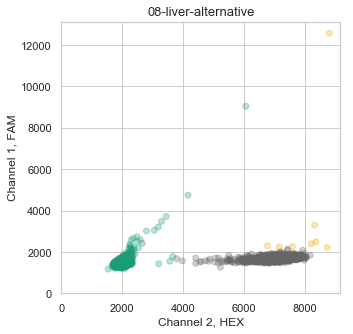

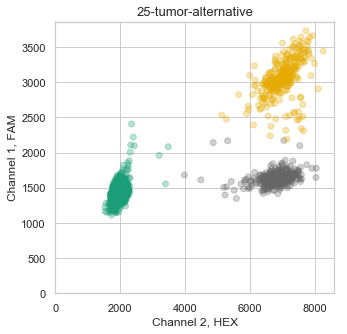

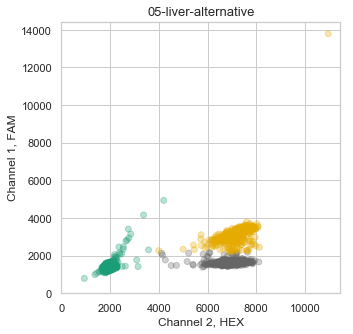

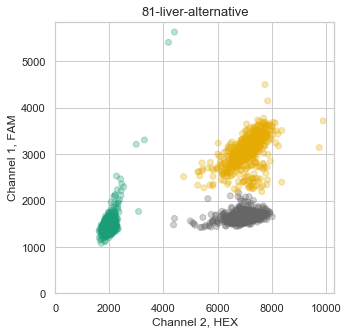

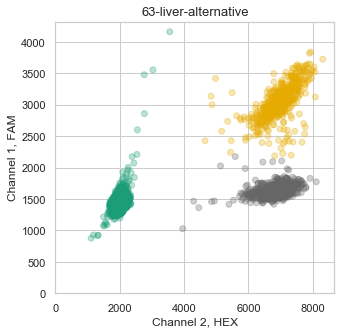

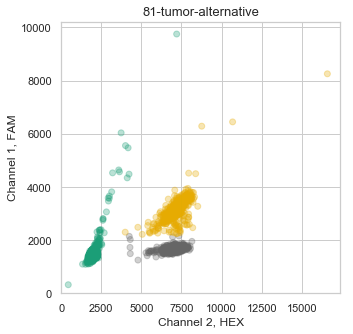

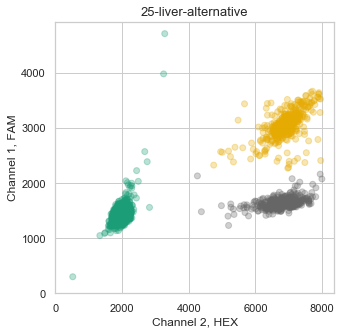

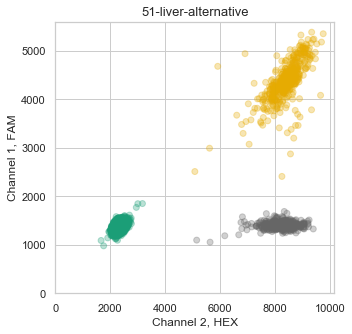

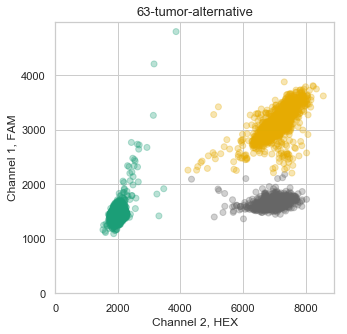

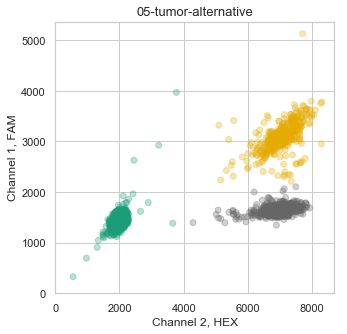

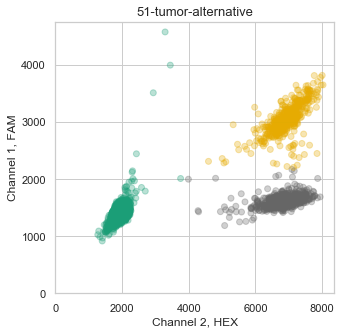

In [126]:
make_cluster_plot("gDNA", "alternative")
# mhp("cDNA", "alternative")

In [137]:
# Stitch hist plot images

def make_one_hist_img():
    
    fig=plt.figure(figsize=(6, 6),dpi=300)
    columns = 2
    rows = 2
    pic_path = os.path.join(os.path.dirname(os.getcwd()), "pics", "ddpcr", "for_hist")
    pic_path_for_pic = os.path.join(os.path.dirname(os.getcwd()), "pics", "ddpcr")
    
    pic_name = [i for i in os.listdir(pic_path) if ".png" in i]
    
    for i,j in enumerate(pic_name):
        pic = os.path.join(pic_path, pic_name[i])
        f = plt.imread(pic)
        if i==0:i=1
        fig.add_subplot(rows, columns, i)
        plt.imshow(f)
        plt.axis("off")
    plt.tight_layout()
    plt.subplots_adjust(wspace=.2,bottom=.1)
#     plt.savefig(os.path.join(pic_path_for_pic, "hist_stitch.png"), dpi=400, bbox_inches="tight")
    
    return None






# Stitch scatter plot images

def make_one_scat_img():
    
    fig=plt.figure(figsize=(6, 6), dpi=300)
    columns = 2
    rows = 2
    
    pic_path = os.path.join(os.path.dirname(os.getcwd()), "pics", "ddpcr", "for_scatter")
    pic_path_for_pic = os.path.join(os.path.dirname(os.getcwd()), "pics", "ddpcr")
    
    pic_name = [i for i in os.listdir(pic_path) if ".png" in i]
    pic_name.sort()

    for i,j in enumerate(pic_name):
        pic = os.path.join(pic_path, pic_name[i])
        f = plt.imread(pic)
#         if i==0:i=1
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(f)
        plt.axis("off")
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2,bottom=.1)
    plt.savefig(os.path.join(pic_path_for_pic, "scatter_stitch.png"), dpi=400, bbox_inches="tight")
    
    return None

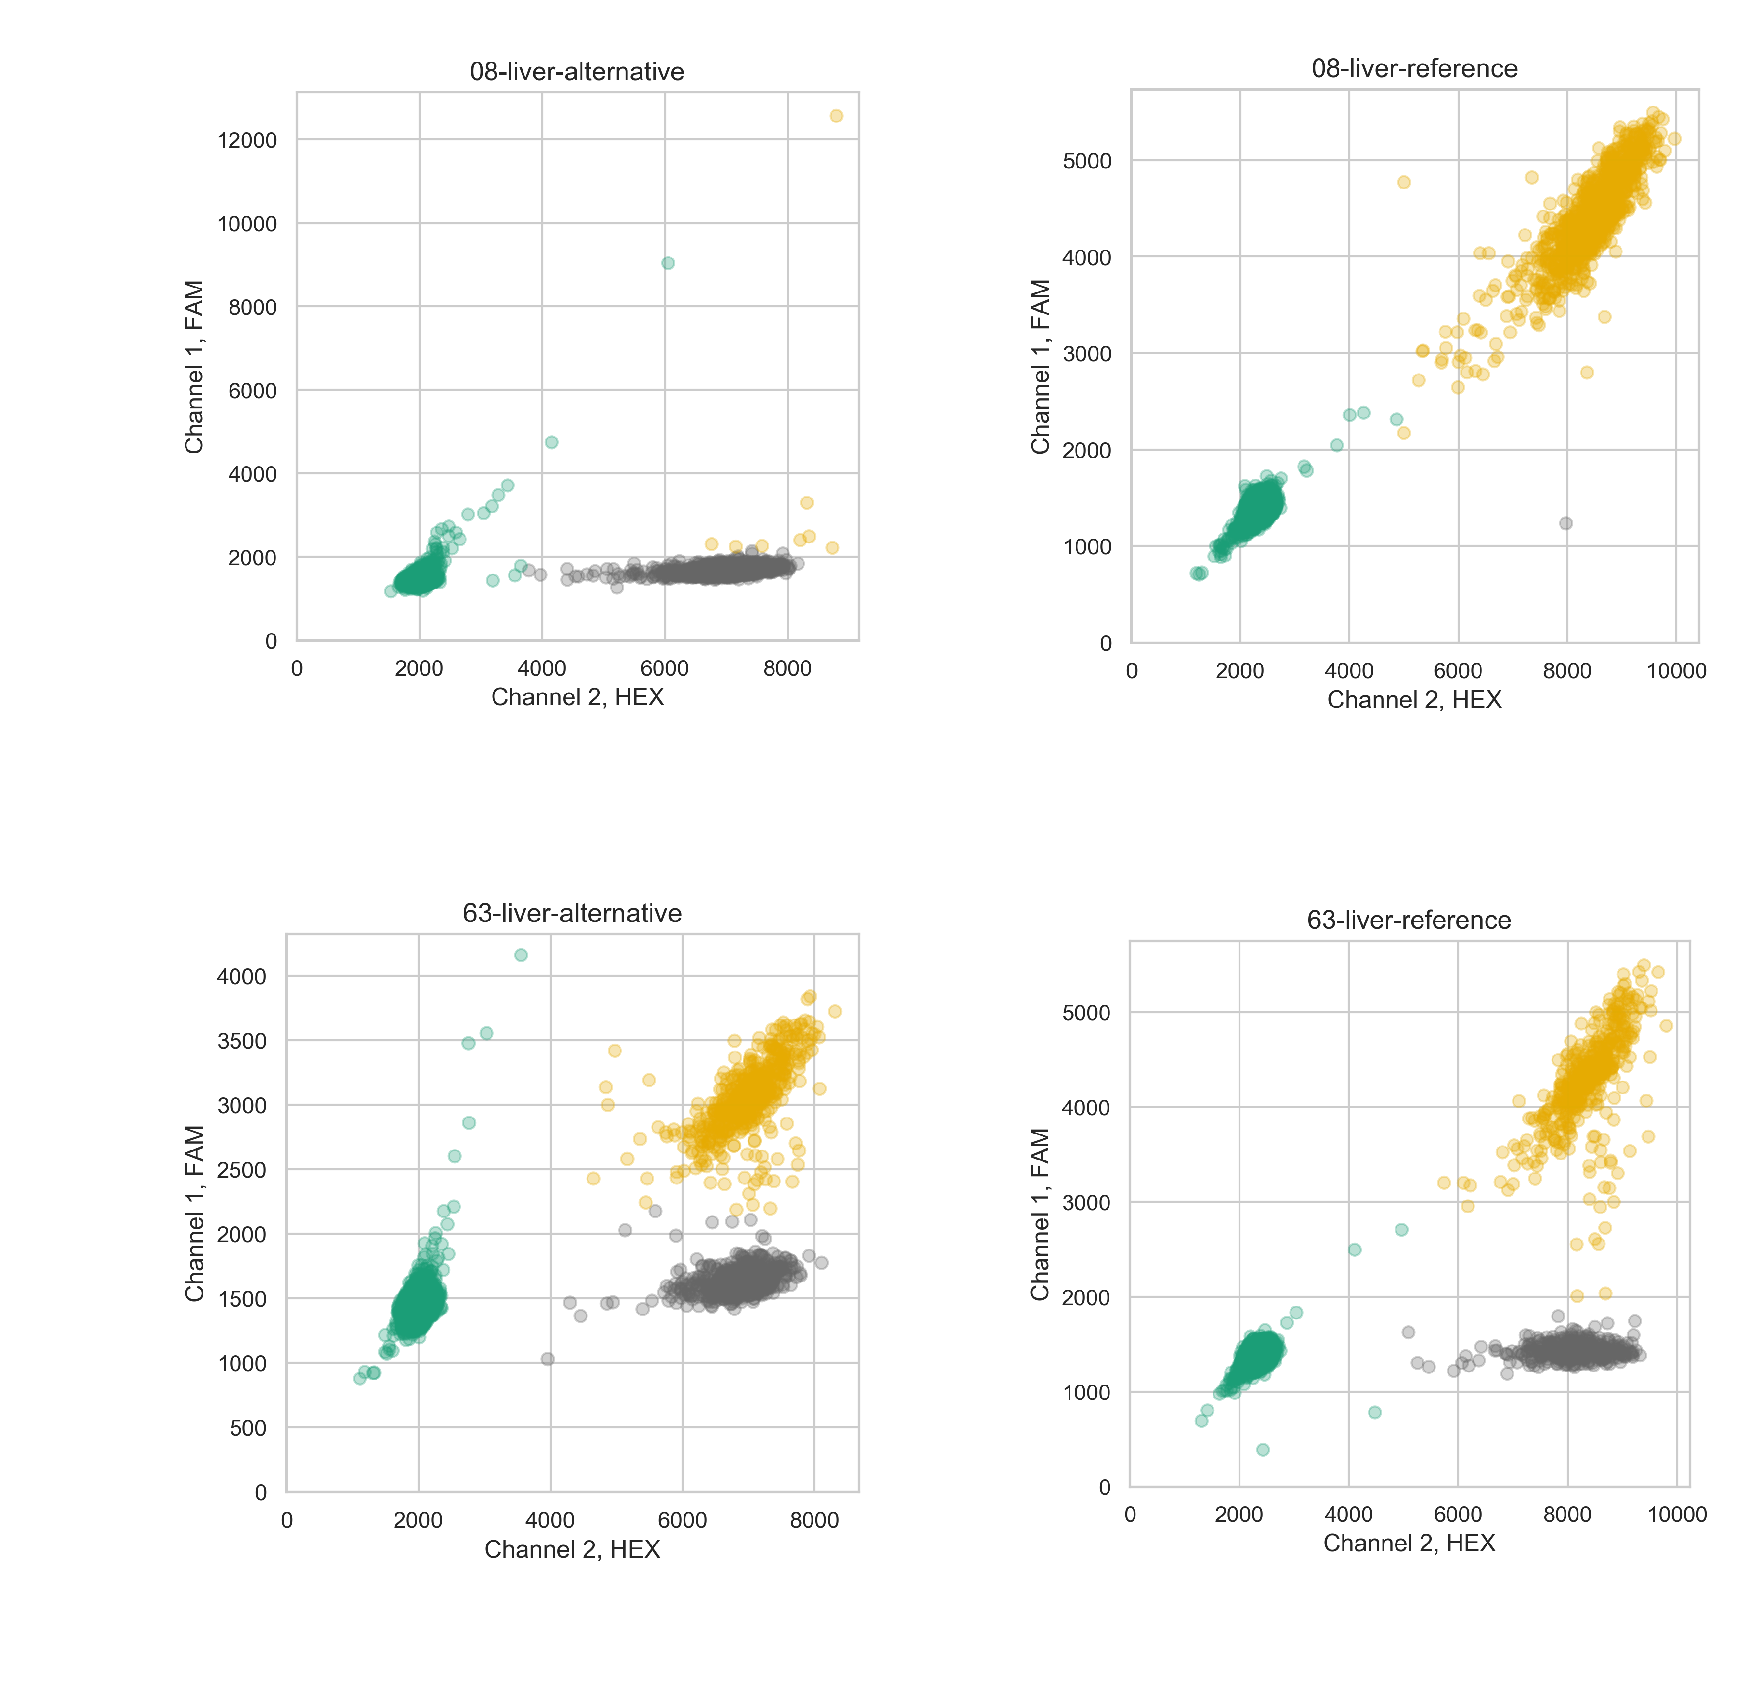

In [138]:
# make_one_hist_img()
make_one_scat_img()

In [44]:
pic_path=os.path.join(os.path.dirname(os.getcwd()), "pics", "ddpcr")

In [45]:
pic_name = [i for i in os.listdir(pic_path) if ".png" in i]

In [47]:
pics = [os.path.abspath(i) for i in os.listdir(pic_path) if ".png" in i]

In [48]:
pics

['/home/emir/Documents/lab/paper_ase/scripts/gDNA reference.png',
 '/home/emir/Documents/lab/paper_ase/scripts/gDNA alternative.png',
 '/home/emir/Documents/lab/paper_ase/scripts/cDNA reference.png',
 '/home/emir/Documents/lab/paper_ase/scripts/cDNA alternative.png']

In [49]:
pic_path

'/home/emir/Documents/lab/paper_ase/pics/ddpcr'